# Gesture Recognition
In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started. Once you have completed the code you can download the notebook for making a submission.

In [1]:
import numpy as np
import os
from imageio import imread
from skimage.transform import resize
import datetime
import os
import matplotlib.pyplot as plt
%matplotlib inline

We set the random seed so that the results don't vary drastically.

In [2]:
np.random.seed(30)
import random as rn
rn.seed(30)
from tensorflow import keras
import tensorflow as tf
tf.random.set_seed(30)

In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

**data path: /home/datasets/Project_data**

In [3]:
train_doc = np.random.permutation(open('F:\\UPGRAD\\5. Deep Learning\\Module 6 - Gesture recognition assignment\\Project_data\\Project_data\\train.csv').readlines())
val_doc = np.random.permutation(open('F:\\UPGRAD\\5. Deep Learning\\Module 6 - Gesture recognition assignment\\Project_data\\Project_data\\val.csv').readlines())
batch_size = 64 #experiment with the batch size

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [4]:
img_idx=0

In [5]:
x = 20 #umber of images selected in img_idx
y = 120 #size of image 
z = 120 #size of image 

In [6]:
def generator(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    # Range is selected as (5,x+5) so that 20 images from the center of 30 images are selected (5th image to 24th image)
    img_idx = [x for x in range(5,x+5)] #create a list of image numbers you want to use for a particular video
    while True:
        t = np.random.permutation(folder_list)
        num_batches = len(folder_list)//batch_size # calculate the number of batches
        for batch in range(num_batches): # we iterate over the number of batches
            batch_data = np.zeros((batch_size,x,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    img_new = resize(image,(y,z))
                    
                    img_new = img_new/255 # normalising 
                    
                    batch_data[folder,idx,:,:,0] = (img_new[:,:,0])#normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = (img_new[:,:,1])#normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = (img_new[:,:,2])#normalise and feed in the image
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

        
        # write the code for the remaining data points which are left after full batches
        if (len(folder_list) != batch_size*num_batches):
            print("Batch: ",num_batches+1,"Index:", batch_size)
            batch_size = len(folder_list) - (batch_size*num_batches)
            # new batch size is the rest of the folders present after dividing the batch
            for batch in range(num_batches): # we iterate over the number of batches
                batch_data = np.zeros((batch_size,x,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
                batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
                for folder in range(batch_size): # iterate over the batch_size
                    imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                    for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                        image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                        
                        #crop the images and resize them. Note that the images are of 2 different shape 
                        #and the conv3D will throw error if the inputs in a batch have different shapes
                        img_new = resize(image,(y,z))
                    
                        img_new = img_new/255 # normalising 
                    
                        batch_data[folder,idx,:,:,0] = (img_new[:,:,0])#normalise and feed in the image
                        batch_data[folder,idx,:,:,1] = (img_new[:,:,1])#normalise and feed in the image
                        batch_data[folder,idx,:,:,2] = (img_new[:,:,2])#normalise and feed in the image
                    
                    batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
                yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

In [7]:
curr_dt_time = datetime.datetime.now()
train_path = 'F:\\UPGRAD\\5. Deep Learning\\Module 6 - Gesture recognition assignment\\Project_data\\Project_data\\train'
val_path = 'F:\\UPGRAD\\5. Deep Learning\\Module 6 - Gesture recognition assignment\\Project_data\\Project_data\\val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 10 # choose the number of epochs
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 10


### Model 2: 2D Conv + RNN (Transfer Learning using MobileNet)

In [8]:
batch_size = 10
num_epochs = 10
x = 20 # # x is the number of images
y = 120 # width of the image
z = 120 # height of the image
classes = 5 #5 gestures 
channel = 3 #RGB

In [9]:
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation, Dropout, LSTM, Bidirectional

from keras.applications import mobilenet

from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers.recurrent import LSTM
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers

In [10]:
pretrained_mobilenet = mobilenet.MobileNet(weights='imagenet', include_top=False)

In [11]:
model_6 = Sequential()
model_6.add(TimeDistributed(pretrained_mobilenet,input_shape=(x,y,z,channel)))

model_6.add(TimeDistributed(BatchNormalization()))
model_6.add(TimeDistributed(MaxPooling2D((2, 2))))
model_6.add(TimeDistributed(Flatten()))

model_6.add(GRU(128))
model_6.add(Dropout(0.25))

model_6.add(Dense(128,activation='relu'))
model_6.add(Dropout(0.25))

model_6.add(Dense(5, activation='softmax'))

In [12]:
train_generator6 = generator(train_path, train_doc, batch_size)
val_generator6 = generator(val_path, val_doc, batch_size)

optimiser = optimizers.Adam(lr=0.0001) #write your optimizer
model_6.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model_6.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed (TimeDistri (None, 20, 3, 3, 1024)    3228864   
_________________________________________________________________
time_distributed_1 (TimeDist (None, 20, 3, 3, 1024)    4096      
_________________________________________________________________
time_distributed_2 (TimeDist (None, 20, 1, 1, 1024)    0         
_________________________________________________________________
time_distributed_3 (TimeDist (None, 20, 1024)          0         
_________________________________________________________________
gru (GRU)                    (None, 128)               443136    
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 128)               1

In [13]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, cooldown=1, verbose=1)  # write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

In [14]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [15]:
def plot(history):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,4))
    axes[0].plot(history.history['loss'])   
    axes[0].plot(history.history['val_loss'])
    axes[0].legend(['loss','val_loss'])
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    


    axes[1].plot(history.history['categorical_accuracy'])   
    axes[1].plot(history.history['val_categorical_accuracy'])
    axes[1].legend(['categorical_accuracy','val_categorical_accuracy'])
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    
    plt.show()

In [16]:
history6 = model_6.fit_generator(train_generator6, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator6, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  F:\UPGRAD\5. Deep Learning\Module 6 - Gesture recognition assignment\Project_data\Project_data\train ; batch size = 10


C:\Users\AKHIL\anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
67/67 [==============================] - 662s 10s/step - loss: 1.7729 - categorical_accuracy: 0.2205 - val_loss: 1.2402 - val_categorical_accuracy: 0.5600

Epoch 00001: saving model to model_init_2021-06-2420_10_49.627447\model-00001-1.60868-0.28205-1.24025-0.56000.h5
Epoch 2/10
67/67 [==============================] - 165s 2s/step - loss: 1.1823 - categorical_accuracy: 0.5092 - val_loss: 0.9862 - val_categorical_accuracy: 0.6700

Epoch 00002: saving model to model_init_2021-06-2420_10_49.627447\model-00002-1.16084-0.51741-0.98624-0.67000.h5
Epoch 3/10
67/67 [==============================] - 157s 2s/step - loss: 1.0784 - categorical_accuracy: 0.5957 - val_loss: 0.8033 - val_categorical_accuracy: 0.7500

Epoch 00003: saving model to model_init_2021-06-2420_10_49.627447\model-00003-1.04500-0.62189-0.80328-0.75000.h5
Epoch 4/10
67/67 [==============================] - 159s 2s/step - loss: 0.8000 - categorical_accuracy: 0.7308 - val_loss: 0.7517 - val_categorical_accuracy: 0.74

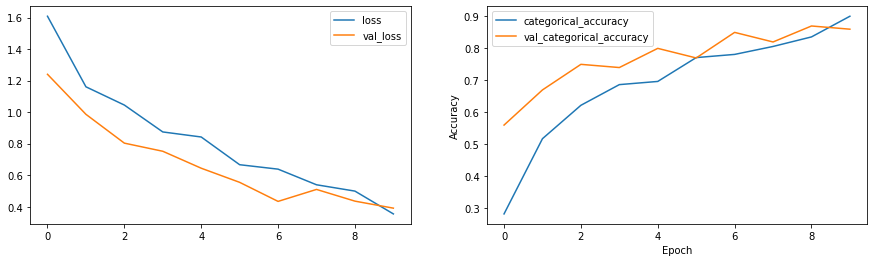

In [17]:
plot(history6)